In [1]:
import numpy as np
import pandas as pd
import keras
print(keras.__version__)

Using TensorFlow backend.


2.2.2


In [2]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import os

# Split in training and test folder

## Create folders

In [19]:
def safefoldercreation(name, path='.'):
    try:
        os.mkdir(os.path.join(path, name))
        print(folder, 'created')
    except:
        print(folder, 'already existing')


In [20]:
folderstructure = ['test', 'train']
for folder in folderstructure:
    safefoldercreation(folder)

test already existing
train already existing


## Re-arrangement

In [6]:
folderlist = ['daisy', 'dandelion', 'sunflower', 'tulip']

In [7]:
pictureclass = {}
for folder in folderlist:
    pictureclass[folder] = [x for x in os.listdir(folder) if x.endswith('.jpg')]
    print('{} - {} pictures'.format(folder, len(pictureclass[folder])))
    

daisy - 633 pictures
dandelion - 898 pictures
sunflower - 699 pictures
tulip - 799 pictures


In [25]:
from sklearn.model_selection import train_test_split
from shutil import copyfile

for flowerclass in pictureclass.keys():
    trainlist = train_test_split(pictureclass[flowerclass], test_size=0.33, random_state=42)[0]
    print(flowerclass, 'trainsize=', len(trainlist))
    
    for folder in folderstructure:
        safefoldercreation(flowerclass, folder)
    
    for file in pictureclass[flowerclass]:
        if file in trainlist:
            folderserie = 'train' 
        else:
            folderserie = 'test'
        copyfile(os.path.join(flowerclass, file), os.path.join(folderserie, flowerclass, file))

dandelion trainsize= 601
test already existing
train already existing
sunflower trainsize= 468
test already existing
train already existing
daisy trainsize= 424
test already existing
train already existing
tulip trainsize= 535
test already existing
train already existing


# Datagenerator creation

In [3]:
image_size = 224
num_class = 4
batch_size = 32
num_channels = 3
train_data_dir = 'train'
validation_data_dir = 'test'

In [4]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(#rotation_range=40,
                                   #shear_range=0.2,
                                   #channel_shift_range=20,
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   #zoom_range=0.2,
                                   #horizontal_flip=True,
                                   #rescale=1./255,
                                    )

test_datagen = ImageDataGenerator() #rescale=1./255

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(image_size,image_size),
                                                    class_mode='categorical',
                                                    batch_size=batch_size)

validation_generator = test_datagen.flow_from_directory(validation_data_dir, 
                                                        target_size=(image_size,image_size),
                                                        class_mode='categorical',
                                                        batch_size=batch_size)

Found 2028 images belonging to 4 classes.
Found 1001 images belonging to 4 classes.


# Transfer learning - Bottlneck

In [5]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model

In [6]:
tr_model=ResNet50(include_top=False,
                  weights='imagenet',
                 input_shape = (224, 224, 3),
                 ) #
#tr_model.summary()

C:\Users\student\Anaconda3\envs\tensorflow\lib\site-packages\keras_applications\resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [7]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(preprocessing_function=preprocess_input) #rescale=1. / 255

In [8]:
# training set
train_generator = datagen.flow_from_directory(train_data_dir,
                                                    target_size=(image_size,image_size),
                                                    class_mode=None,
                                                    batch_size=batch_size,
                                                    shuffle=False)

bottleneck_features_train = tr_model.predict_generator(train_generator)
train_labels = to_categorical(train_generator.classes , num_classes=num_class)

Found 2028 images belonging to 4 classes.


In [9]:
# Validation set
validation_generator = datagen.flow_from_directory(validation_data_dir, 
                                                        target_size=(image_size,image_size),
                                                        class_mode=None,
                                                        batch_size=batch_size,
                                                       shuffle=False)

bottleneck_features_validation = tr_model.predict_generator(validation_generator)
validation_labels = to_categorical(validation_generator.classes, num_classes=num_class)

Found 1001 images belonging to 4 classes.


In [10]:
print(bottleneck_features_train.shape)
print(bottleneck_features_validation.shape)

(2028, 7, 7, 2048)
(1001, 7, 7, 2048)


In [12]:
print(train_labels.shape)
print(validation_labels.shape)

(2028, 4)
(1001, 4)


## Model creation

In [13]:
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, regularizers
model = Sequential()
model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
#model.add(Dense(1024, activation='relu'))

#model.add(BatchNormalization())
#model.add(Dropout(0.85))

model.add(Dense(num_class, activation='softmax', name='pred'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
pred (Dense)                 (None, 4)                 401412    
Total params: 401,412
Trainable params: 401,412
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Early stop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')

In [15]:
history = model.fit(bottleneck_features_train, train_labels,
          epochs=15,
          batch_size=batch_size,
          validation_data=(bottleneck_features_validation, validation_labels),
                   callbacks = [early])

Train on 2028 samples, validate on 1001 samples
Epoch 1/15
2028/2028 [==============================] - 3s 1ms/step - loss: 4.5673 - acc: 0.6696 - val_loss: 4.2294 - val_acc: 0.7203
Epoch 2/15
2028/2028 [==============================] - 2s 1ms/step - loss: 3.8846 - acc: 0.7470 - val_loss: 4.0759 - val_acc: 0.7283
Epoch 3/15
2028/2028 [==============================] - 2s 1ms/step - loss: 3.1577 - acc: 0.7934 - val_loss: 1.7747 - val_acc: 0.8611
Epoch 4/15
2028/2028 [==============================] - 2s 1ms/step - loss: 1.3114 - acc: 0.9043 - val_loss: 1.1972 - val_acc: 0.9091
Epoch 5/15
2028/2028 [==============================] - 2s 1ms/step - loss: 0.8286 - acc: 0.9384 - val_loss: 1.4348 - val_acc: 0.8951
Epoch 6/15
2028/2028 [==============================] - 2s 1ms/step - loss: 0.7010 - acc: 0.9472 - val_loss: 1.4438 - val_acc: 0.8931
Epoch 7/15
2028/2028 [==============================] - 2s 1ms/step - loss: 0.6175 - acc: 0.9546 - val_loss: 1.2915 - val_acc: 0.9051
Epoch 00007: e

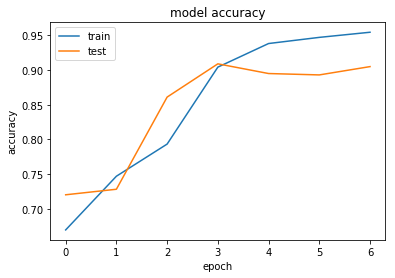

In [18]:
import matplotlib.pyplot as plt
import numpy

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

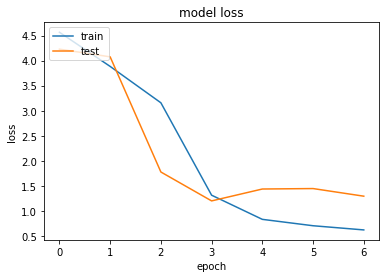

In [17]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()